# TSIA201 TP1 : Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**Practical work done by : IQBI Hamza**

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from scipy import signal
import time
import pyaudio

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## 1. Conversion of sampling rate :

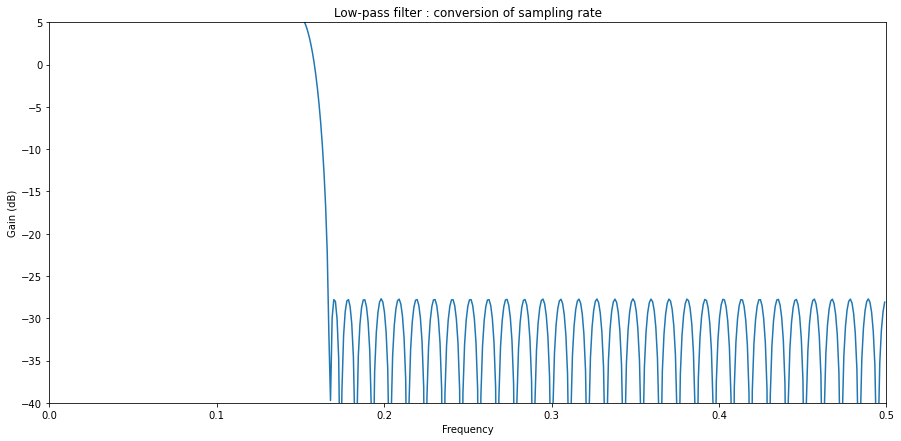

In [3]:
########## Q1

def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(15)   
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.set_xlim(0, 0.5*fs)
    #ax.grid(True)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)
    

fs = 1
cutoff = 1/6
trans_width = 1/60  # Width of transition from pass band to stop band, Hz
numtaps = 95      # Size of the FIR filter.
h = signal.remez(numtaps, [0, cutoff - trans_width, cutoff, 0.5*fs], [1, 0])
W, H = signal.freqz(h, [1])
plot_response(fs, W, 2*H, "Low-pass filter : conversion of sampling rate") 
#2*H because the remez implementation does not converge for an amplitude 2

The reconstruction with the simple implementation of the filter took : 0.2164313793182373


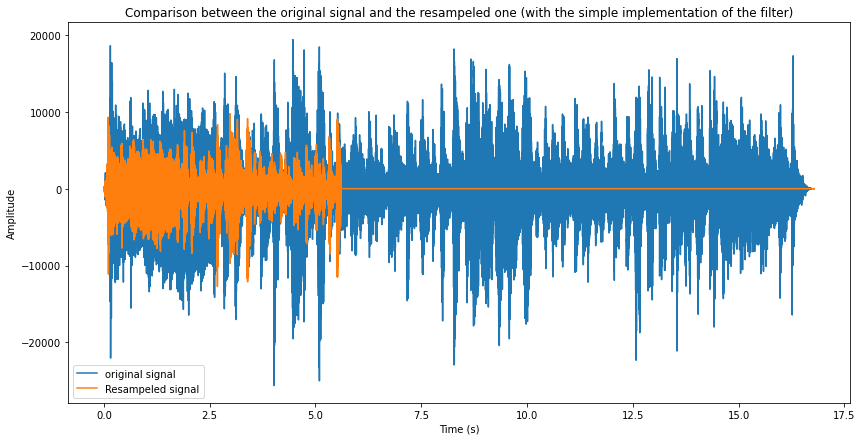

In [4]:
########## Q2

def upsampling(x, L) :
    w = np.zeros(len(x))
    for n in range(0, len(x)) :
        if n%L == 0 : w[n] = x[n//L]
    return w

def downsampling(x, M):
    y = np.zeros(len(x))
    for n in range(0, len(x)//M) : y[n] = x[n*M]
    return y

def resampling(x, L, M):
    maxi = max(L, M)
    cutoff = 1/(2*maxi)
    trans_width = cutoff/10
    numtaps = 100
    h = signal.remez(numtaps, [0, cutoff - trans_width, cutoff, 0.5], [1, 0])
    w = upsampling(x, L)
    v = signal.lfilter(h, [1], w)
    y = downsampling(v, M)
    return y

data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
#print(wavefile.getparams())

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

t_simple_before = time.time()
out_simple = resampling(x, 2, 3)
t_simple_after = time.time()
print("The reconstruction with the simple implementation of the filter took :", t_simple_after-t_simple_before)

fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(14)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Comparison between the original signal and the resampeled one (with the simple implementation of the filter)")
plt.plot(times, x, label = "original signal")
plt.plot(times, out_simple, label = "Resampeled signal")
plt.legend()

The construction with the efficient implementation of the filter took 0.20560121536254883


Text(0, 0.5, 'Amplitude')

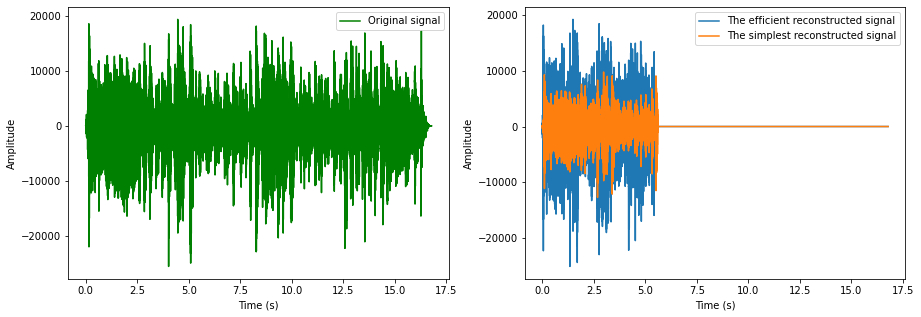

In [5]:
########## Q3 Q4

#We will adopt the typeI polyphase components because the complexity in this case is reduced by a factor of M**2 (and M>L)

N = len(h)
M = 3
L = 2

E0 = [h[k*M] for k in range(N//M)]
E1 = [h[k*M+1] for k in range((N-1)//M)]
E2 = [h[k*M+2] for k in range((N-2)//M)]

t_efficient_before = time.time()
out_0 = signal.lfilter(E0, [1], downsampling(x, M))
out_1 = signal.lfilter(E1, [1], downsampling(signal.lfilter([0., 1.], [1], x), M))
out_2 = signal.lfilter(E2, [1], downsampling(signal.lfilter([0., 0., 1.], [1], x), M))
out_efficient = out_0 + out_1 + out_2
t_efficient_after = time.time()
print("The construction with the efficient implementation of the filter took", t_efficient_after - t_efficient_before)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

plt.title("Comparison between the original signal and the resampeled ones")

plt.subplot(1, 2, 1)
plt.plot(times, x, label = "Original signal", color = 'g')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
plt.plot(times, out_efficient, label = "The efficient reconstructed signal")
plt.plot(times, out_simple, label = "The simplest reconstructed signal")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

### 2. STFT audio equalization :

#### 2.1 STFT analysis :

C:\Users\IQBI Hamza\AppData\Local\Temp\ipykernel_11200\452651705.py:8: RuntimeWarning: divide by zero encountered in log10
  response = 20*np.log10(np.abs(np.fft.fftshift(w_hat)))


Text(0.5, 1.0, 'DFT (of size 2048) of a Hanning window (of size 512)')

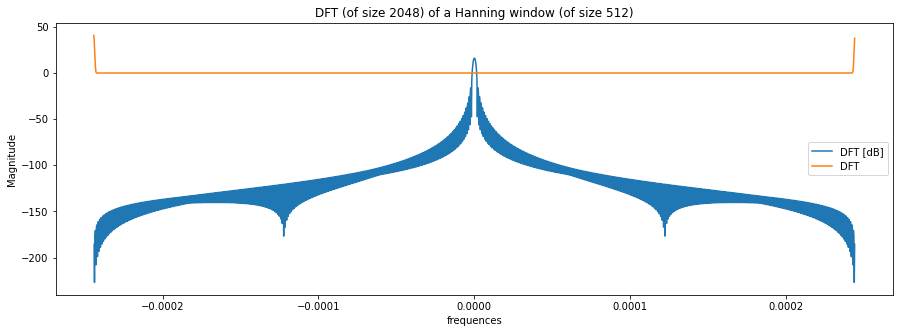

In [6]:
########## Q1

Nw = 512
w = np.hanning(Nw)
M = 2048
w_hat = np.fft.fft(w, M) / 40
frequences = np.linspace(-0.5, 0.5, M)
response = 20*np.log10(np.abs(np.fft.fftshift(w_hat)))

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.plot(frequences/M, response, label = "DFT [dB]")
plt.plot(frequences/M, np.abs(w_hat)**2, label = "DFT")
plt.xlabel('frequences')
plt.ylabel('Magnitude')
plt.legend()
title = "DFT (of size {}) of a Hanning window (of size {})"
plt.title(title.format(M, Nw))

In [7]:
########## Q3

Fs = int(wavefile.getframerate())
N = x.shape[0]
M = 32
R = 1
L = M//2+1
Nw = M - 1
k = 3
w = np.hanning(Nw)
Nt = np.rint((N - Nw) / R)
Nt = Nt.astype(int)


X_tilde = np.zeros((M, Nt), dtype=complex)
for u in np.arange(0, Nt).reshape(-1):
    tram = np.multiply(x[np.arange(int(u*R+1), int(u*R+1+Nw))], w)
    X_tilde[:, u] = np.fft.fft(tram, M)

Text(0, 0.5, 'Frequency (Hz)')

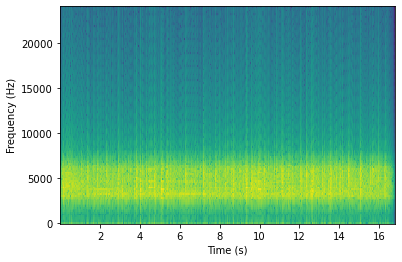

In [8]:
#----- The filtering interpretation of X_tilde -----#

f_cible = 4500
b, a = signal.butter(10, [2*f_cible/Fs-2/(Nw), 2*f_cible/Fs+2/(Nw)], btype="band")
X_filter = signal.lfilter(b, a, x)
f, t, Sxx = signal.spectrogram(X_filter, Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequencey (Hz)')

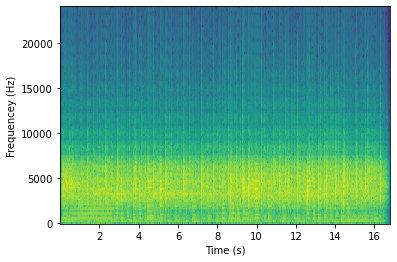

In [9]:
#----- The spectrogram interpretation of X_tilde -----#

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(13)

plt.subplot(1, 2, 2)
f, t, Sxx = signal.spectrogram(np.real(X_tilde[k, :]), Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.xlabel('Time (s)')
plt.ylabel('Frequencey (Hz)')

In [10]:
#----- Playing x_k -----#

play = False
if play :
    write('Real_xk.wav', Fs, np.array(np.real(X_tilde[k, :]), dtype=np.int16))
    data_path = os.getcwd()
    filename = 'Real_xk.wav'
    sound = os.path.join(data_path, filename) 
    wavefile = load_sound(sound)
    play_sound(sound)

#### 2.2 Reconstruction :

1.0000000000000369


Text(0.5, 0, 'Time (s)')

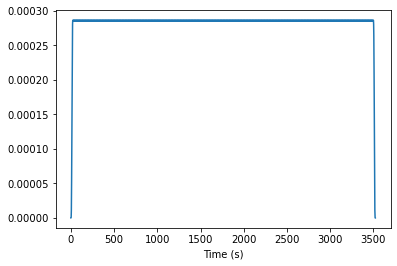

In [11]:
########## Q4

overlap = 0.75

def ola(w = None, hop = None, Nb = 10): 

    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) 
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k * hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

h = w/np.sqrt(5625)
f = ola(h**2, hop = int((1-overlap)*len(w)), Nb = 500)
print(sum(f)[0])

plt.plot(f)
plt.xlabel('Time (s)')

In [12]:
########## Q5

#----- Computing the reconstructed signal -----#
def reconst(X_t, w, R, M, Nw, N):
    xreconst = np.zeros(N)
    for b in np.arange(0, X_t.shape[1]):
        start = int(R*b + 1)                  # Start of the interval 
        end = int(R*b + 1 + Nw)               # End of the interval
        inv = np.fft.ifft(X_t[:, b], M)         # Calculates the inverse FFT
        term = np.multiply(inv[:Nw], w)  # Multiply the inverse with the window
        xreconst[np.arange(start, end)] = xreconst[np.arange(start, end)] + term
    return xreconst 

x_reconst = reconst(X_tilde, w, R, M, Nw, N)


C:\Users\IQBI Hamza\AppData\Local\Temp\ipykernel_11200\4093180011.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  xreconst[np.arange(start, end)] = xreconst[np.arange(start, end)] + term


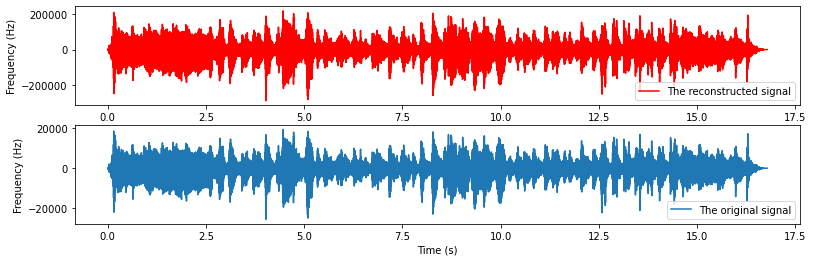

In [13]:
#----- Comparing the two signals : the original and the reconstructed -----#

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(13)

plt.subplot(2, 1, 1)
plt.plot(times, x_reconst, label = "The reconstructed signal", color = 'r')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, x, label = "The original signal")
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()

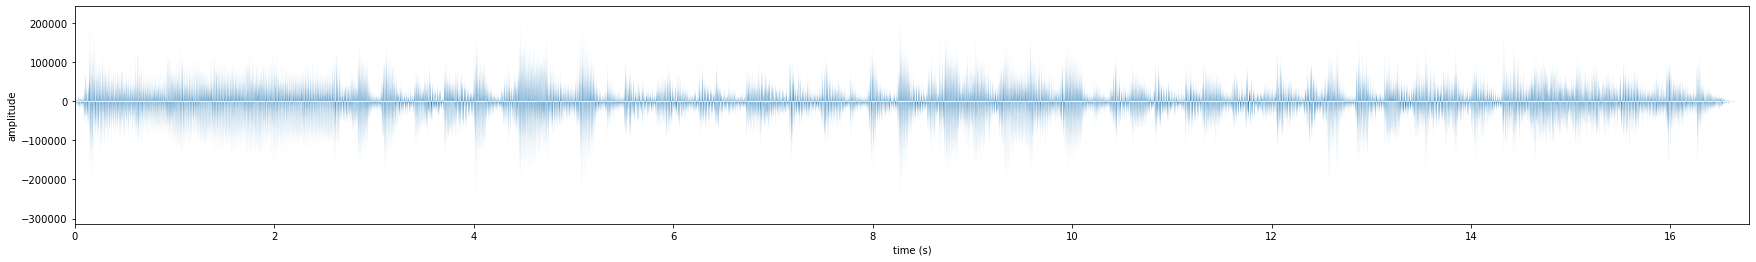

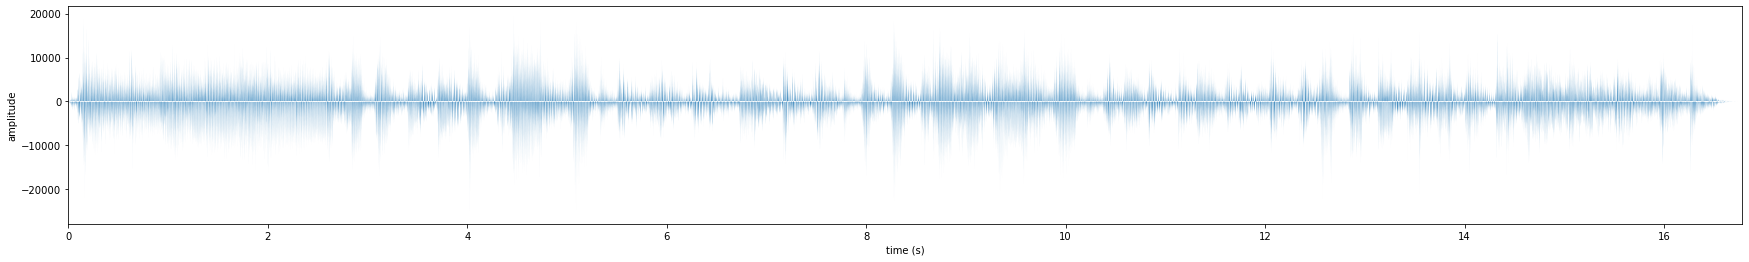

In [14]:
#----- Another comparison between the original signal and the reconstrudcted one : we cannot distinguish which is which
plot_sound(x_reconst, times)
plot_sound(x, times)

In [15]:
########## Q6

def equalizer(X_t, M, R, weights, k, Nw, N, w) :
    y_s_un = np.zeros(N)
    for b in range(0, X_t.shape[1]) :
        deb = int(R*b+1)
        fin = deb+Nw
        y_sn = np.fft.ifft(np.multiply(X_t[:, b], weights), M)
        term = np.multiply(y_sn[:Nw], w)
        y_s_un[np.arange(deb, fin)] = y_s_un[np.arange(deb, fin)] + term
    return y_s_un